# Fig 1: CA2-silenced mice spend more time near the old platform location during reversal learning in the Morris water maze

In [1]:
import numpy as np
from tqdm import tqdm
import expipe
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.patches as patches
import copy
import tools as tls
import measures as ms
from scipy import signal
import scipy.stats as stats
import spatial_maps as sm
from scipy.ndimage import gaussian_filter



import plot
import rpy2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from tempfile import TemporaryDirectory
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

rstatix = importr('rstatix')
%load_ext autoreload
%autoreload 2

## Params

In [2]:
path = 'data/expipe'

dt = 0.1 # dt in s for temporal interpolation

d_pltfrm = 0.1 # diameter platform in m

t_max = 60 # seconds, maximal time assigned if animal does not reach platform

annulus_outer_rad = d_pltfrm/2*5
annulus_inner_rad = d_pltfrm/2

# replace TeNT/eYFP with CA2-silenced/control
dct_repl = {
    'TeNT': 'CA2-silenced',
    'eYFP': 'control'}

# define colors for each group
palette = sns.color_palette()
ls_palette = [palette[0], palette[1]]

# occupancy maps
d_pool = 1.2 # diameter of pool in meter
r_pool = d_pool/2.

dx = 0.025 # resolution of spatial occupancy map in m
bins = np.arange(-r_pool, r_pool+dx, dx)

## Load data

In [3]:
# load project
project = expipe.require_project(path)

# get animals and treatment
ls_animal = []
ls_treatment = []
for key, val in project.entities.items():
    ls_animal.append(int(key))
    ls_treatment.append(val.type)
df_animal = pd.DataFrame({'entities': ls_animal, 'treatment':ls_treatment})

# get trial information
ls_df_info = []
for k, v in project.actions.items():
    if v.type == 'MWM':
        dict_i = {
            **v.attributes,
            **v.modules['test'].contents,
            **v.modules['apparatus'].contents,
            **v.modules['zone'].contents,
            **v.data.contents}
        dict_i['entities'] = int(v.entities[0])
        ls_df_info.append(dict_i)
df_info = pd.DataFrame(ls_df_info)
df_info = pd.merge(df_info, df_animal, on='entities')

# Enable ordering across experimental type, day and trial
ls_df_info_i = []
for i in df_animal['entities']:
    df_info_i = df_info[df_info['entities'] == i]
    df_info_i = df_info_i.sort_values(['fname', 'stage', 'trial'])
    df_info_i['order'] = np.arange(len(df_info_i))
    df_info_i['grp_day_trial'] = df_info_i['fname'] + '_' + df_info_i['stage'] + '_' + df_info_i['trial']
    df_info_i['grp_day'] = df_info_i['fname'] + '_' + df_info_i['stage']
    ls_df_info_i.append(df_info_i)
df_info = pd.concat(ls_df_info_i)

#### Sort df_info
df_info = df_info.reset_index(drop=True)

#### Convert maze info to meter and center
df_info = tls.convert_center_df_info(df_info)

### add adjusted days for plotting
sorted_groups = {
    'MWM_Day1': r'day 3',
    'MWM_Day2': r'day 4',
    'MWM_Day3': r'day 5',
    'MWM_Day4': r'day 6',
    'MWM_Day5': r'day 7',
    'MWM_Probe': r'day 8',
    'MWM-Rev_Day1': r'day 9',
    'MWM-Rev_Day2': r'day 10',
    'MWM-Rev_Day3': r'day 11',
    'MWM-Rev_Day4': r'day 12',
    'MWM-Rev_Day5': r'day 13',
    'MWM-Rev_Probe': r'day 14',}

ls_d = [sorted_groups[d] for d in df_info['grp_day']]
df_info['days_adjusted'] = ls_d

# Get maze information
row_0 = df_info.loc[0]

# check whether info dict is identical for all rows
assert(np.all([row_0['info'] == row_j['info'] for _, row_j in df_info.iterrows()]))

# position of platform
pos_platform = {}
grp = df_info.groupby('fname')
for i, grp_i in grp:
    grp_i_0 = grp_i.iloc[0]
    assert(np.all([
        grp_i_0['Platform'] == grp_i_j['Platform'] for _, grp_i_j in grp_i.iterrows()]))
    xy_pltfrm_i = np.array([
        float(grp_i_0['Platform']['centre']['x']),
        float(grp_i_0['Platform']['centre']['y'])])
    pos_platform[grp_i_0['fname']] = xy_pltfrm_i

# scaling factor pixel to meter
pixelspermetre = float(row_0['pixelspermetre'])

# signs of quadrants
signs_quadr = {}
for quadr_i in ['NW', 'NE', 'SW', 'SE']:
    quadr_center = [
        grp_i_0[quadr_i]['centre']['x'],
        grp_i_0[quadr_i]['centre']['y']]
    signs_quadr[quadr_i] = np.sign(quadr_center)

## Compute measures and occupancy maps

In [4]:
ls_res = []

for i, row_i in tqdm(df_info.iterrows()):

    df_pos_i = pd.read_pickle(row_i['data']['position_data'])

    # get time
    t = np.array(df_pos_i['tm'].astype(float))
    
    # get coordinates
    x = np.array(df_pos_i['c_x'].astype(float))
    y = np.array(df_pos_i['c_y'].astype(float))
    
    # rescale to m
    x *= 1/pixelspermetre
    y *= 1/pixelspermetre
    
    xy = np.vstack((x, y)).T

    # center coordinates
    xy_center = np.array([
        row_i['info']['centre']['x'],
        row_i['info']['centre']['y']])
    xy -= xy_center

    # exclude nan values
    xy, t = tls.exclude_nan_values(xy, t)

    # interpolate xy values
    xy, t = tls.interpolate_xy_values(xy, t, dt)
    
    # get current platform location
    xy_pltfrm = pos_platform[row_i['fname']]

    
    # compute measures
    # ----------------------
    res = {}
    
    # trial duration
    res['trial duration'] = np.max(t)
    
    # path length
    res['path length'] = ms.path_length(xy)
    
    #  fraction of time in target quadrant and opposite quadrant
    time_targetquadrant = ms.time_in_quadrant(xy, t, np.sign(xy_pltfrm))
    res['fraction of time in target quadrant'] = time_targetquadrant/np.max(t)
    
    # measures related to platform position
    for key, pos_pltfrm in pos_platform.items():
        if key == 'MWM':
            name = 'original'
        elif key == 'MWM-Rev':
            name = 'relocated'
        
        # mean distance to platform cente           
        res['mean distance to center of ' + name + ' platform'
           ] = ms.mean_distance_to_point(xy, t, pos_pltfrm)
       
        # mean distance to platform center
        res['mean distance to center of' + name + ' platform'
           ] = ms.mean_distance_to_point(xy, t, pos_pltfrm)
    
    # occupancy maps
    occ_map = sm.maps._occupancy_map(
        xy[:,0],
        xy[:,1],
        t,
        bins,
        bins)
    # convert occupancy to s/cm^2 by the following logic
    # -> s/pxl = 6.25*s/cm^2
    occ_map = occ_map*(dx*100)**2
    
    
    #res['occupancy_map'] = np.ma.array(occ_map, mask=bool_bin_in_pool[:-1, :-1])
    res['occupancy_map'] = occ_map
    
    ls_res.append(res)
df_res = pd.DataFrame(ls_res)

df_info = df_info.join(df_res)

756it [00:01, 493.99it/s]


## Posthoc test - trial duration/path length

In [5]:
# Define units for measures
dct_ms_units = {
    'trial duration': 'seconds',
    'path length': 'meter',
    'mean distance to center of original platform': 'meter',
    'mean distance to center of relocated platform': 'meter',
    'fraction of time in target quadrant': '',
}

In [6]:
day_sel = [
    'day 3',
    'day 4',
    'day 5',
    'day 6',
    'day 7',
    'day 9',
    'day 10',
    'day 11',
    'day 12',
    'day 13']

ls_p = []
for day_i in day_sel:
    df_sel = df_info[
        (df_info['days_adjusted'] == day_i)]
    df_sel

    dict_p = {}
    dict_p['day'] = day_i

    for meas_i in dct_ms_units.keys():
        gp = df_sel.groupby('treatment')
        values = {i: gp_i[meas_i] for i, gp_i in gp}

        p = stats.mannwhitneyu(
            x=values['TeNT'],
            y=values['eYFP'],
            alternative = 'greater')[1]
        dict_p[meas_i] = p
    ls_p.append(dict_p)
df_p = pd.DataFrame(ls_p)

df_p[['day', 'trial duration', 'path length']]

,day,trial duration,path length
0,day 3,0.570753,0.542867
1,day 4,0.035676,0.031148
2,day 5,0.725987,0.668690
3,day 6,0.128542,0.287413
4,day 7,0.186829,0.235882
5,day 9,0.385047,0.369074
6,day 10,0.005078,0.006854
7,day 11,0.118138,0.134598
8,day 12,0.071095,0.089653
9,day 13,0.024305,0.040971


## Plot measures


In [7]:
df_info = df_info[df_info['stage'] != 'Probe']
df_info = df_info.reset_index()

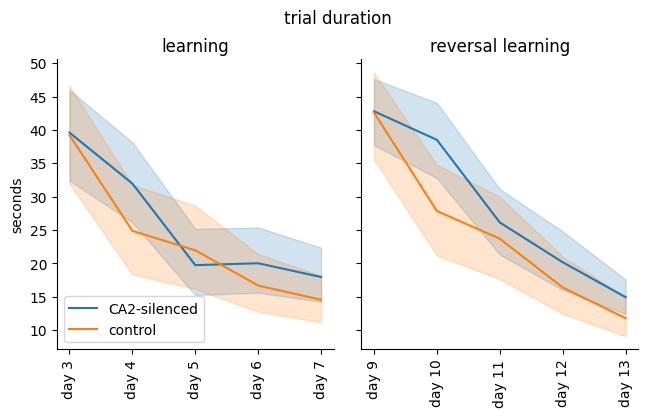

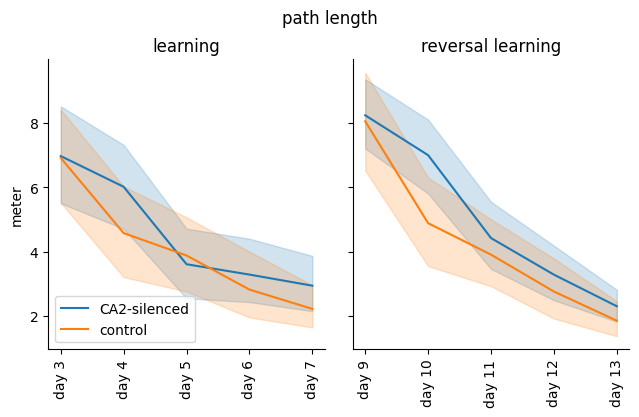

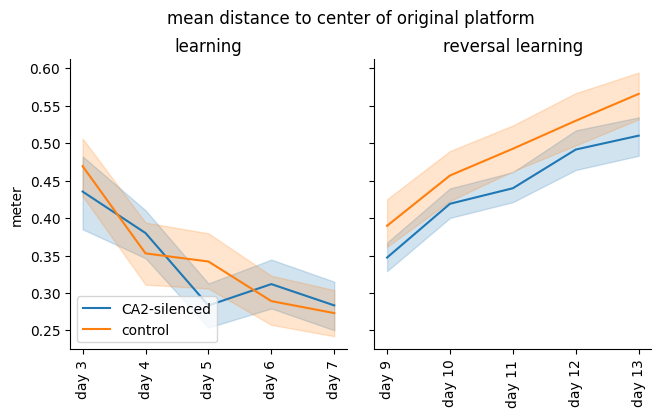

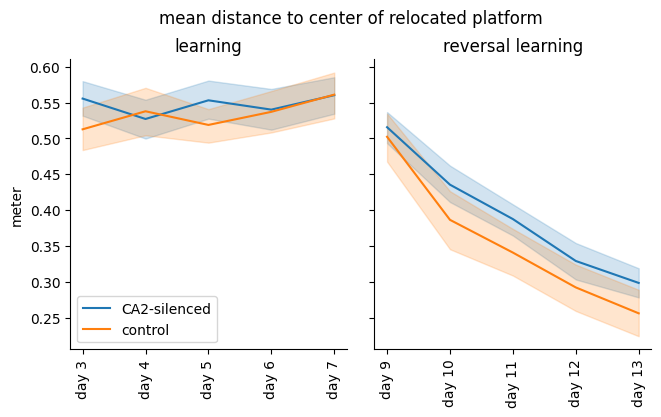

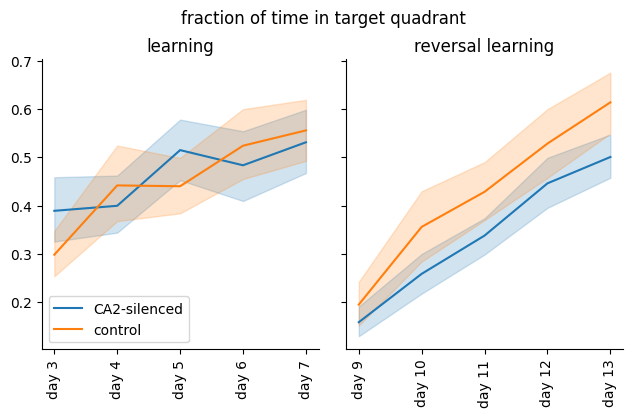

In [8]:
day = [key.split('_')[1] for key in df_info['grp_day']]
df_info['day'] = day

for ms_i, unit_i in dct_ms_units.items():
    plot.plot_measure_learning_relearning(
        df_info,
        ms_i,
        unit_i,
        dct_repl,
        palette=ls_palette,
        fname='figures/'+ms_i.replace(' ', '_')+'.pdf')

## Statistical analysis
Two-way repeated measures Anova to compare different measures

In [9]:
dct_names = {
    'MWM': 'Learning',
    'MWM-Rev': 'Reversal-Learning'}

In [10]:
for meas_i in dct_ms_units.keys():
    print('\n\n------------------------\n')
    print(meas_i + '\n')

    ls_sel = [
        meas_i,
        'fname',
        "entities",
        "stage",
        "grp_day",
        "grp_day_trial",
        "trial",
        "treatment"]    
    df_sel = df_info[ls_sel]
    
    # exclude probe trials
    df_sel[df_sel['stage'] != 'Probe']

    for fname_i, phase_i in dct_names.items():
        print('\n')
        print(phase_i)
        df_sel_i = df_sel[df_sel['fname'] == fname_i]

        with localconverter(ro.default_converter + pandas2ri.converter):
            df_sel_i_r = ro.conversion.py2rpy(df_sel_i)

        aov = rstatix.anova_test(
            data=df_sel_i_r,
            dv=meas_i,
            wid='entities',
            within='grp_day_trial',
            between='treatment')

        with localconverter(ro.default_converter + pandas2ri.converter):
            aov_pd = ro.conversion.rpy2py(aov)
        print(aov_pd)



------------------------

trial duration



Learning
                    Effect   DFn    DFd      F             p p<.05    ges
1                treatment   1.0   16.0  0.701  4.150000e-01        0.005
2            grp_day_trial  19.0  304.0  5.794  2.300000e-12     *  0.243
3  treatment:grp_day_trial  19.0  304.0  0.672  8.460000e-01        0.036


Reversal-Learning
                    Effect   DFn    DFd       F             p p<.05    ges
1                treatment   1.0   16.0   1.139  3.020000e-01        0.017
2            grp_day_trial  19.0  304.0  10.973  6.640000e-25     *  0.340
3  treatment:grp_day_trial  19.0  304.0   0.990  4.730000e-01        0.044


------------------------

path length



Learning
                    Effect   DFn    DFd      F             p p<.05    ges
1                treatment   1.0   16.0  1.535  2.330000e-01        0.005
2            grp_day_trial  19.0  304.0  5.868  1.490000e-12     *  0.258
3  treatment:grp_day_trial  19.0  304.0  0.632  8.81000

## Occupancy maps

In [11]:
### Params
dct_treat = {
    r'CA2-silenced': 'TeNT',
    r'control': 'eYFP'}
vmin = 0.
vmax = 0.08*(dx*100)**2
dct_kwargs = {
    'subplots': {
        'figsize': (5, 10),
        'gridspec_kw': {
            'wspace':0.04,
            'hspace':0.04,
            'width_ratios': [0.3, 0.35, 0.35]}
    },
    'imshow': {
        'vmin': vmin,
        'vmax': vmax,
        'extent': [
            -r_pool,
            r_pool,
            -r_pool,
            r_pool]
    },
    'colorbar': {
        'orientation': 'horizontal',
        'ticks': [vmin, vmax],
        'label': r'Occupancy $\frac{s}{cm²}$'
    }
}

fac_scale_border = 1.1
fac_scale_pltfrm = 1.5


In [12]:
# Calculate average maps across treatment and days
ls_group_vars = ['grp_day', 'treatment']
grps = df_info.groupby(ls_group_vars)
ls_res = []
for grp_i, grp_val in grps:
    res = {}
    occ_map = np.mean(np.dstack(grp_val['occupancy_map']), axis=2)

    # filter image
    occ_map = gaussian_filter(occ_map, 1)
    
    # mark values outside of pool with nan
    map_dist_center = np.sqrt(np.add.outer(bins**2, bins**2))
    bool_bin_in_pool = map_dist_center<r_pool
    occ_map = np.ma.masked_where(
        ~bool_bin_in_pool[1:, 1:], occ_map)
    
    res['occupancy_map'] = occ_map
    
    for j, var_j in enumerate(ls_group_vars):
        res[var_j] = grp_i[j]
    ls_res.append(res)
df_meanmap = pd.DataFrame(ls_res)


/home/jovyan/work/plot.py:235: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


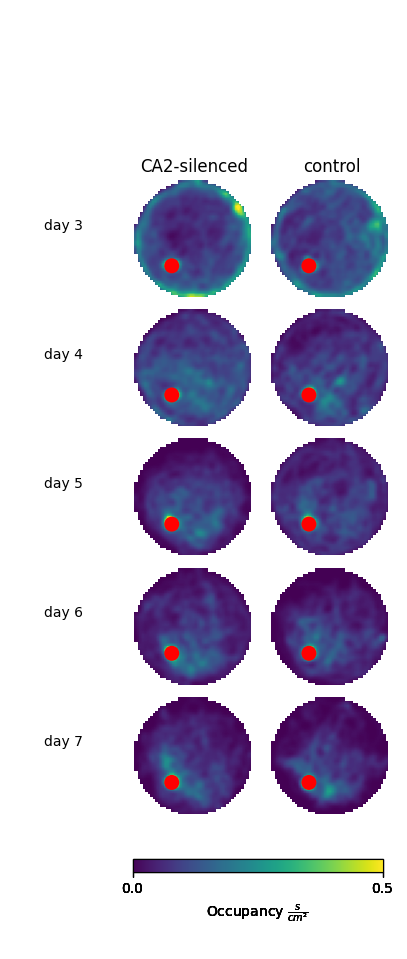

In [16]:
sorted_groups_only_learning = {k: v for k, v in sorted_groups.items() if '-Rev' not in k and not '_Probe' in k}
pos_pltfrm = np.copy(pos_platform['MWM'])
pos_pltfrm[1] = pos_pltfrm[1]*-1. # switch location to match imshow orientation

plot.plot_occupancy_maps(
    df_meanmap, sorted_groups_only_learning, dct_treat,
    r_pool, fac_scale_border, fac_scale_pltfrm,
    pos_pltfrm, d_pltfrm, pos_pltfrm_old=None,
    fname='figures/occupancy_learning.pdf',
    dct_kwargs=dct_kwargs)

/home/jovyan/work/plot.py:235: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


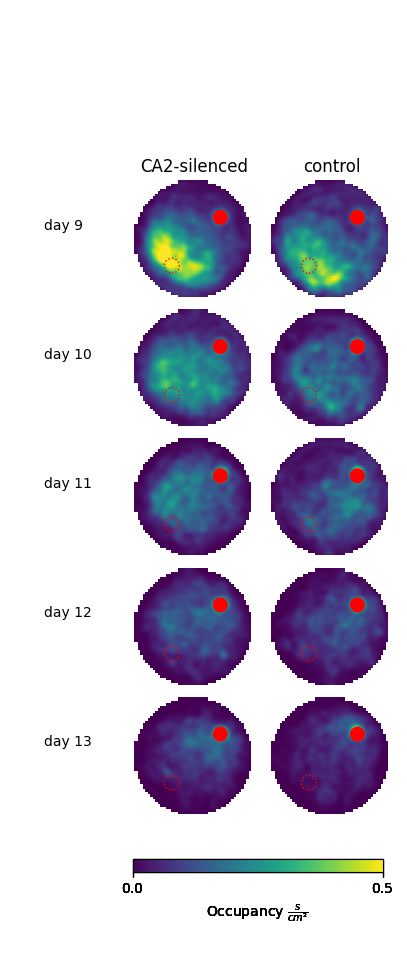

In [15]:
sorted_groups_only_relearning = {k: v for k, v in sorted_groups.items() if '-Rev' in k and not '_Probe' in k}
pos_pltfrm = np.copy(pos_platform['MWM-Rev'])
pos_pltfrm[1] *= -1. # switch location to match imshow orientation
pos_pltfrm_old = np.copy(pos_platform['MWM'])
pos_pltfrm_old[1] *= -1. # switch location to match imshow orientation


plot.plot_occupancy_maps(
    df_meanmap, sorted_groups_only_relearning, dct_treat,
    r_pool, fac_scale_border, fac_scale_pltfrm, 
    pos_pltfrm, d_pltfrm, pos_pltfrm_old,
    fname='figures/occupancy_reversallearning.pdf',
    dct_kwargs=dct_kwargs)